In [1]:
#set up sys
import os, sys
sys.path.append('../PMC_func')


#python basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from collections import Counter

#spacy stuff
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
import en_core_web_sm

#gensim stuff
from gensim.models import CoherenceModel, LdaMulticore,LdaModel
from gensim.models.callbacks import ConvergenceMetric
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this

#custom dependencies
import PMC_module

#other
import pickle
import warnings
warnings.filterwarnings('ignore')

### Import Data
- Pickled Gensim Objects
- Composite Data Frame

In [2]:
nogram_filename = "../pickled_data/nogram_corpus.pkl"
bigram_filename = "../pickled_data/bigram_corpus.pkl"
trigram_filename = "../pickled_data/trigram_corpus.pkl"
df_lemmatized_texts = "../pickled_data/df_lemmatized_texts.pkl"

with open(nogram_filename, "rb") as f:
    nogram_list_lemmatized_texts, nogram_corpus, nogram_id2word = pickle.load(f)

with open(bigram_filename, "rb") as g:
    bigram_list_lemmatized_texts, bi_corpus, bi_id2word = pickle.load(g)
    
with open(trigram_filename, "rb") as h:
    trigram_list_lemmatized_texts, tri_corpus, tri_id2word = pickle.load(h)
    
with open(df_lemmatized_texts, "rb") as m:
    df_lemmatized_texts = pickle.load(m)

In [3]:
# store raw texts as a list for later
df_list = df_lemmatized_texts.text.tolist()

### Gensim LDA modeling - Hyper Parameter Tunning

#### Coherence Score

In [4]:
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

convergence_logger = ConvergenceMetric(logger='shell')

In [5]:
num_topics_list = list(range(5,20,5))
model_lists = []
coherence_list = []

chunksize = 1000
passes = 4
iterations = 200
eval_every = 1
callbacks = [convergence_logger]

for num_topics in num_topics_list:
    lda_model = LdaModel(id2word=nogram_id2word, 
                         num_topics=num_topics,
                         corpus=nogram_corpus,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         callbacks= callbacks)
                             
    coherence_model_lda = CoherenceModel(model=lda_model, texts=nogram_list_lemmatized_texts, dictionary=nogram_id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    model_lists.append(lda_model)
    coherence_list.append(coherence_score)
    print("LDA model/coherence complete for num_topics = ",num_topics, "; score = ", coherence_score)

LDA model/coherence complete for num_topics =  5 ; score =  0.4841115584710563
LDA model/coherence complete for num_topics =  10 ; score =  0.47048816528886617
LDA model/coherence complete for num_topics =  15 ; score =  0.4453586740791151


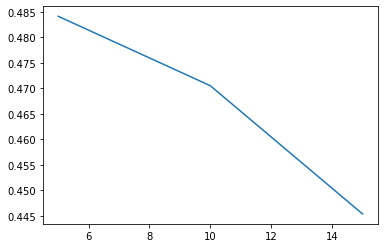

In [6]:
plt.plot(num_topics_list,coherence_list)

#### Topic Component Distribution - 5 topics

In [25]:
opt_topic_index = 0
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

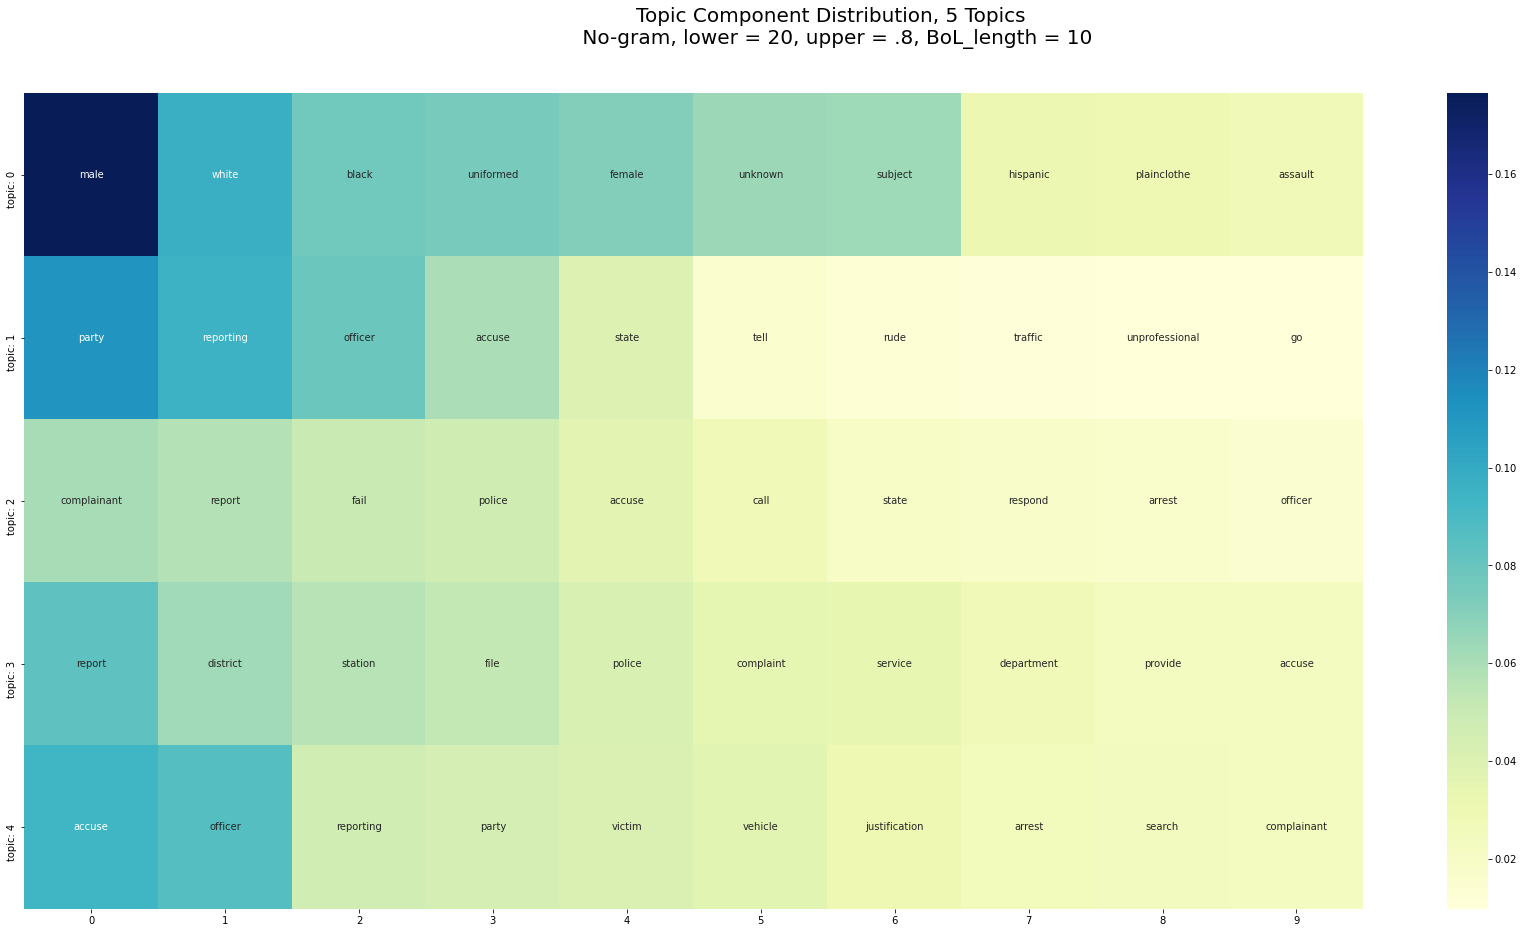

In [26]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n No-gram, lower = 20, upper = .8, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_nogram_5topics1.png')

#### pyLDAvis Principal Component Visualization

In [9]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_nogram_5topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], nogram_corpus, nogram_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [10]:
dom_topic_df_5 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],nogram_corpus, nogram_list_lemmatized_texts,df_list)
top_representatives_5 = PMC_module.return_top_representatives(dom_topic_df_5, num_reps = 10)

In [11]:
top_representatives_5[top_representatives_5['Dominant_Topic'] == 4].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
40,28267,4.0,0.9589,"[accuse, officer, reporting, party, victim, ve...","[reporting, party, allege, accuse, officer, de...",The reporting party alleged that the accused\...
41,28268,4.0,0.9589,"[accuse, officer, reporting, party, victim, ve...","[reporting, party, allege, accuse, officer, de...",The reporting party alleged that the accused\...
42,32882,4.0,0.9480,"[accuse, officer, reporting, party, victim, ve...","[victim, allege, accuse, officer, enter, home,...",The victims alleges that the accused\nofficers...
43,32879,4.0,0.9478,"[accuse, officer, reporting, party, victim, ve...","[victim, allege, accuse, officer, enter, home,...",The victims alleges that the accused\nofficers...
44,5389,4.0,0.9455,"[accuse, officer, reporting, party, victim, ve...","[tis, allege, civil, suit, ee, accuse, probabl...","tis alleged in a Civil Suit, Ee\naccused had n..."
45,32878,4.0,0.9372,"[accuse, officer, reporting, party, victim, ve...","[victim, allege, accuse, officer, enter, home,...",The victims alleges that the accused\nofficers...
46,12102,4.0,0.9362,"[accuse, officer, reporting, party, victim, ve...","[reporting, party, allege, acuse, officer, for...",THE REPORTING PARTY ALLEGES THAT\nTHE ACUSED O...
47,5388,4.0,0.9304,"[accuse, officer, reporting, party, victim, ve...","[allege, civil, suit, accuse, probable, cause,...","It is alleged in a Civil Suit, the\naccused ha..."
48,12100,4.0,0.9276,"[accuse, officer, reporting, party, victim, ve...","[reporting, party, allege, acuse, officer, for...",THE REPORTING PARTY ALLEGES THAT\nTHE ACUSED O...
49,3016,4.0,0.9271,"[accuse, officer, reporting, party, victim, ve...","[victim, allege, accuse, officer, probable, ca...",The victim alleges that the accused officers\n...


In [12]:
topic_of_interest = 4
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_5[top_representatives_5['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 4
---------
 The reporting party alleged that the accused
officer destroyed the victim's personal
property and residence during a search
warrant and searched two vehicles without
probable cause.
The reporting party alleged that the accused
officer destroyed the victim's personal
property and residence during a search
warrant and searched two vehicles without
probable cause.
The reporting party alleged that the accused
officer destroyed the victim's personal
property and residence during a search
warrant and searched two vehicles without
probable cause.
The reporting party alleged that the accused
officer destroyed the victim's personal
property and residence during a search
warrant and searched two vehicles without
probable cause.
The reporting party alleged that the accused
sergeant destroyed the victim's personal
property and residence during a search
warrant and searched two vehicles without
probable cause.
The reporting party alleged that the accused
officer destroyed the vi

#### Topic Component Distribution - 10 topics

In [27]:
opt_topic_index = 1
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

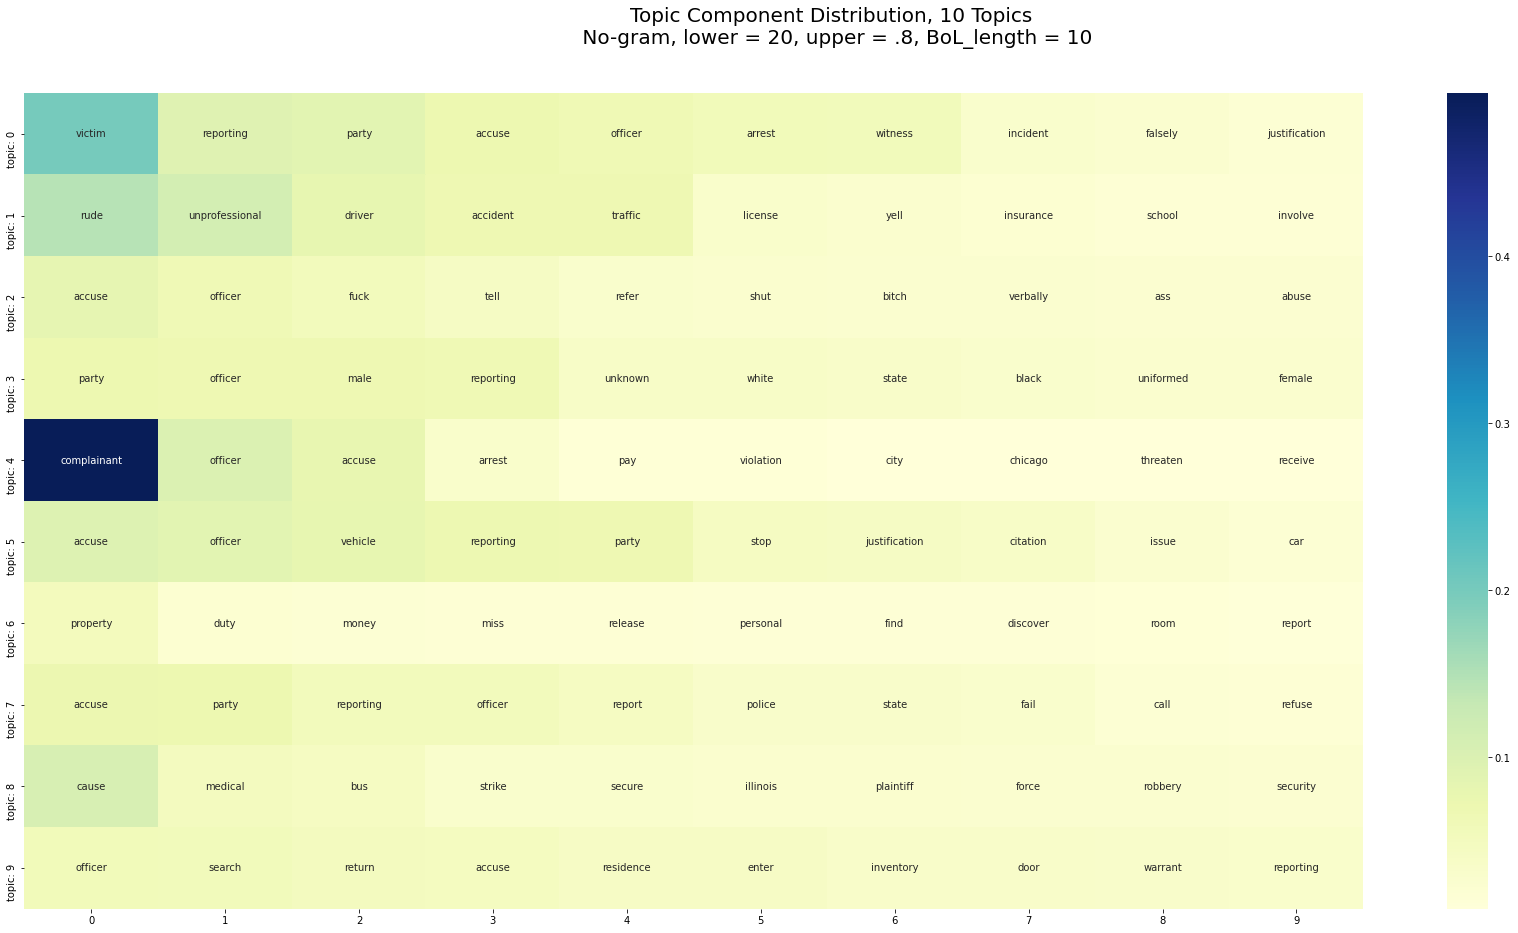

In [28]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 10 Topics \n No-gram, lower = 20, upper = .8, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_nogram_10topics1.png')

#### pyLDAvis Principal Component Visualization

In [15]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_nogram_10topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], nogram_corpus, nogram_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [16]:
dom_topic_df_10 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],nogram_corpus, nogram_list_lemmatized_texts,df_list)
top_representatives_10 = PMC_module.return_top_representatives(dom_topic_df_10, num_reps = 10)

In [31]:
top_representatives_10[top_representatives_10['Dominant_Topic'] == 1].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
10,34162,1.0,0.3668,"[rude, unprofessional, driver, accident, traff...","[complainant, allege, accuse, officer, fail, p...",The complainant alleges that the accused\noffi...
11,34163,1.0,0.3667,"[rude, unprofessional, driver, accident, traff...","[complainant, allege, accuse, officer, fail, p...",The complainant alleges that the accused\noffi...
12,25874,1.0,0.3637,"[rude, unprofessional, driver, accident, traff...","[reporting, party, allege, accuse, officer, ru...",The reporting party alleges that the accused\n...
13,8305,1.0,0.3635,"[rude, unprofessional, driver, accident, traff...","[reporting, party, allege, ride, bike, strike,...",The reporting party alleged that while he\nwas...
14,8647,1.0,0.3455,"[rude, unprofessional, driver, accident, traff...","[unknown, officer, rude, unprofessional, throw...",unknown officer was rude and\nunprofessional b...
15,33631,1.0,0.3380,"[rude, unprofessional, driver, accident, traff...","[complainant, allege, accuse, officer, rude, u...",The complainant alleges that the accused\noffi...
16,33630,1.0,0.3380,"[rude, unprofessional, driver, accident, traff...","[complainant, allege, accuse, officer, rude, u...",The complainant alleges that the accused\noffi...
17,26221,1.0,0.3341,"[rude, unprofessional, driver, accident, traff...","[reporting, party, allege, involve, traffic, a...",The reporting party alleged that she was\ninv...
18,26222,1.0,0.3341,"[rude, unprofessional, driver, accident, traff...","[reporting, party, allege, involve, traffic, a...",The reporting party alleged that she was\ninvo...
19,19456,1.0,0.3315,"[rude, unprofessional, driver, accident, traff...","[reporting, party, allege, accuse, rude, unpro...",‘The reporting party alleged that the accused\...


In [32]:
topic_of_interest = 1
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_10[top_representatives_10['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 1
---------
The complainant alleges that the accused
officers failed to provide him with adequate
police services regarding traffic accident
that he was involved in and driving on a
suspended driver's license.
The complainant alleges that the accused
officers failed to provide him with adequate
police services regarding a traffic accident
that he was involved in and driving on a
suspended driver's license.
------
The complainant alleges that the accused
officers failed to provide him with adequate
police services regarding a traffic accident
that he was involved in and driving on a
suspended driver's license.
The complainant alleges that the accused
officers failed to provide him with adequate
police services regarding traffic accident
that he was involved in and driving on a
suspended driver's license.
------
The reporting party alleges that the accused
officer was rude and unprofessional in that
he used aggressive and threatening
language during the issuance of a traffic
citat

#### Topic Component Distribution - 15 topics

In [34]:
opt_topic_index = 2
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

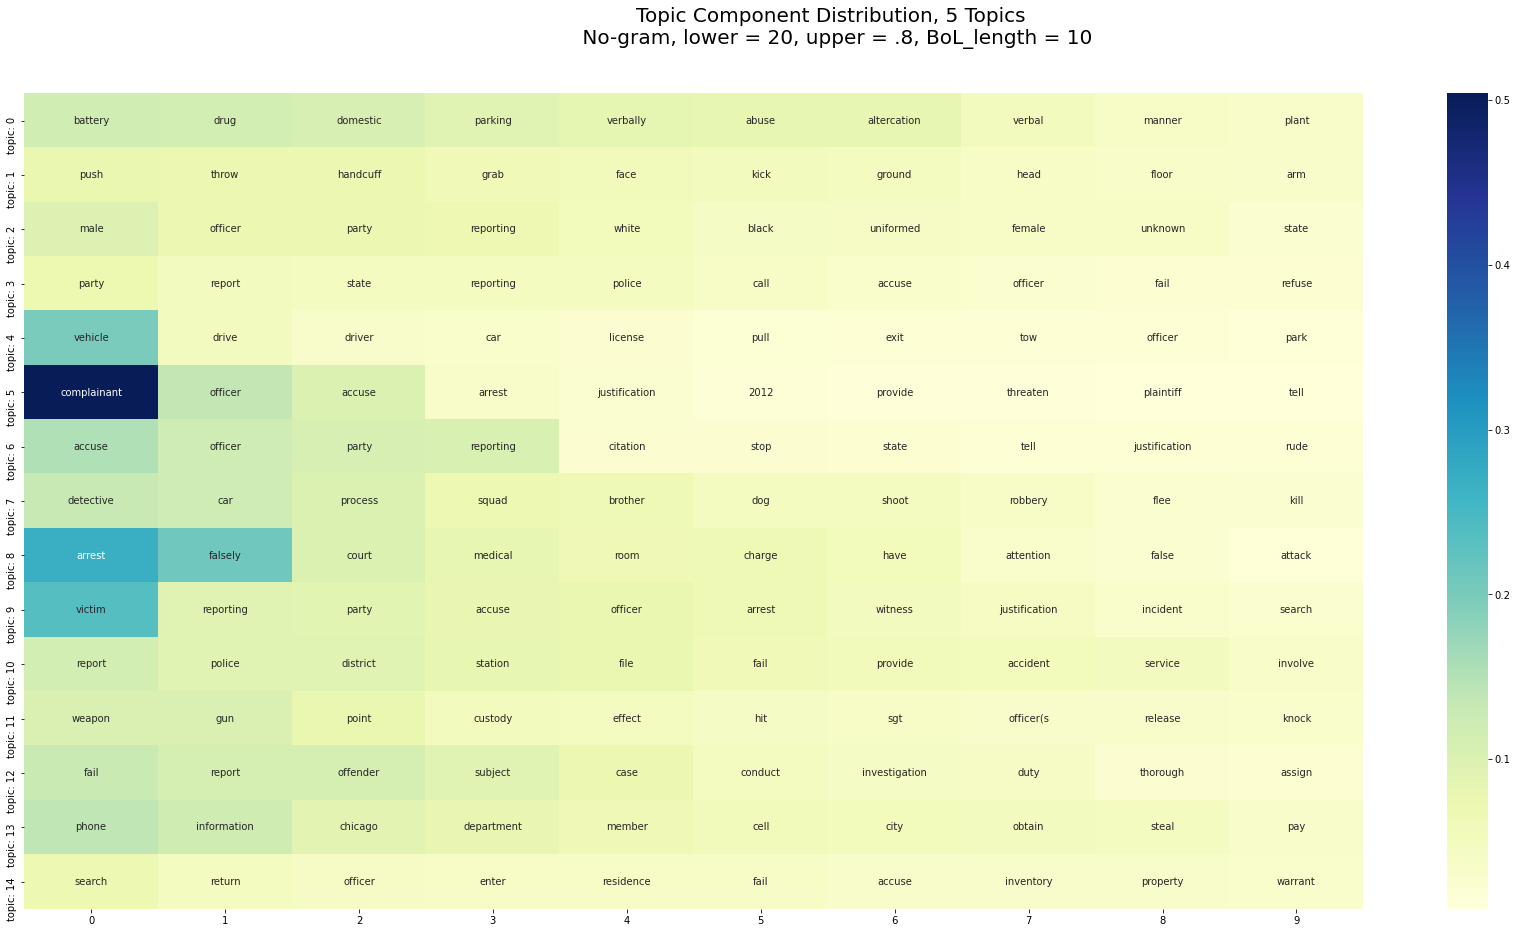

In [35]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n No-gram, lower = 20, upper = .8, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_nogram_15topics1.png')

#### pyLDAvis Principal Component Visualization

In [21]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_nogram_15topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], nogram_corpus, nogram_id2word)
pyLDAvis.save_html(vis, visualization_name)

#### Most Represetative Documents


In [22]:
dom_topic_df_15 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],nogram_corpus, nogram_list_lemmatized_texts,df_list)
top_representatives_15 = PMC_module.return_top_representatives(dom_topic_df_15, num_reps = 10)

In [36]:
top_representatives_15[top_representatives_15['Dominant_Topic'] == 4].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
40,8302,4.0,0.5568,"[vehicle, drive, driver, car, license, pull, e...","[pull, illegally, park, bus, stop, allege, off...",pulled up and illegally parked at the bus\nsto...
41,28035,4.0,0.5316,"[vehicle, drive, driver, car, license, pull, e...","[reporting, party, allege, accuse, stop, passe...",The reporting party alleged that the accused\n...
42,7708,4.0,0.5212,"[vehicle, drive, driver, car, license, pull, e...","[friend, nfi, drive, car, accuse, attempt, pul...","and her friend, _\n(NFI), were driving in car ..."
43,28034,4.0,0.5106,"[vehicle, drive, driver, car, license, pull, e...","[reporting, party, allege, accuse, stop, husba...",The reporting party alleged that the accused\...
44,15447,4.0,0.5015,"[vehicle, drive, driver, car, license, pull, e...","[complainant, allege, drive, i-94, inbound, 22...",The complainant alleges that while driving\non...
45,20371,4.0,0.4965,"[vehicle, drive, driver, car, license, pull, e...","[allege, 22, feb, 2013, 2100, 2300, hour, ride...",\nIt is alleged that on 22 Feb 2013 between\n...
46,7060,4.0,0.4942,"[vehicle, drive, driver, car, license, pull, e...","[report, vehicle, abandon, park, locaiton, app...",It is reported that the above vehicle is\n“aba...
47,17651,4.0,0.4938,"[vehicle, drive, driver, car, license, pull, e...","[reporting, party, allege, accuse, officer, il...",The Reporting Party alleges that the\naccused ...
48,17652,4.0,0.4938,"[vehicle, drive, driver, car, license, pull, e...","[reporting, party, allege, accuse, officer, il...",The Reporting Party alleges that the\naccused ...
49,8303,4.0,0.4919,"[vehicle, drive, driver, car, license, pull, e...","[reporting, party, allege, wait, fora, cta, bu...",The reporting party alleged that while she\nwa...


In [37]:
topic_of_interest = 4
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_15[top_representatives_15['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 4
---------
pulled up and illegally parked at the bus
stop. It is further alleged that one of the
officers exited the vehicle and went inside a
restaurant.
------
The reporting party alleged that the accused
stopped her h and
his passenger ,in the vehicle,
at which time they discovered that her
husband's driver's license was suspended
The accused failed to allow the passenger,
who had valid a driver's
license to drive the car. Instead, one of the
officers drove her vehicle to the 009th and
had her car impounded
------
and her friend, _
(NFI), were driving in car when
the accused attempted to pull over to the
location where an arrest was taking place
(there were several marked cars attending
to the incident.) It is alleged that the
accused drove erratically and endangered
other drivers when he drove without lights
and put the car in reverse in the middle of
traffic without signalling, almost hitting a
pedestrian a car.
------
 The reporting party alleged that the accused
stopped 